In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import Bio
import Bio.SeqIO
import re
import os
import pickle

from timeit import default_timer as timer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from timeit import default_timer as timer


/tmp/ipykernel_1342/3395517339.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch

/home/yisupeng/.conda/envs/py310/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/yisupeng/.conda/envs/py310/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/yisupeng/.conda/envs/py310/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMP

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'

In [5]:
hyper_aa_regex = re.compile('[BXZJUO]')

In [6]:
MAX_LEN = 20

In [7]:
import torch

In [8]:
modelname = 'prot_20'

In [9]:
states_dir = f'states/{modelname}/'
if not os.path.exists(states_dir):
    os.makedirs(states_dir)

In [10]:
seq_file = "data/uniprot_sprot.fasta"
# seq_file = "data/debugging_sequence.fasta"


seqdb_pickle = f'{states_dir}/seqdb.pickle'
if os.path.exists(seqdb_pickle):
    seqdb = pickle.load(open(seqdb_pickle, 'rb'))
else:
    seqdb = {}
    irregs = 0
    for record in Bio.SeqIO.parse(seq_file, "fasta"):
        if '|' in record.id:
            _, acc, geneid = record.id.split('|')
        else:
            acc = record.id
        if hyper_aa_regex.findall(str(record.seq)):
            irregs += 1
            continue
        # if len(record.seq) > MAX_LEN:
        #     irregs += 1
        #     continue
        seqdb[acc] = record
    print('irregs', irregs)
    pickle.dump(seqdb, open(seqdb_pickle, 'wb'))
    seqdb = pickle.load(open(seqdb_pickle, 'rb'))



In [11]:
len(seqdb)

568610

In [12]:
def build_datapoint(s):
    return list(s)

In [13]:
def build_dataset(seqdb):
    res = []
    for acc, rec in seqdb.items():
        res.append(build_datapoint(str(rec.seq)))
    return res

In [14]:
for rec in seqdb.values():
    if 'B' in rec.seq:
        print(rec)
        break

In [15]:
ds = build_dataset(seqdb)
ds[:10]

[['M',
  'A',
  'F',
  'S',
  'A',
  'E',
  'D',
  'V',
  'L',
  'K',
  'E',
  'Y',
  'D',
  'R',
  'R',
  'R',
  'R',
  'M',
  'E',
  'A',
  'L',
  'L',
  'L',
  'S',
  'L',
  'Y',
  'Y',
  'P',
  'N',
  'D',
  'R',
  'K',
  'L',
  'L',
  'D',
  'Y',
  'K',
  'E',
  'W',
  'S',
  'P',
  'P',
  'R',
  'V',
  'Q',
  'V',
  'E',
  'C',
  'P',
  'K',
  'A',
  'P',
  'V',
  'E',
  'W',
  'N',
  'N',
  'P',
  'P',
  'S',
  'E',
  'K',
  'G',
  'L',
  'I',
  'V',
  'G',
  'H',
  'F',
  'S',
  'G',
  'I',
  'K',
  'Y',
  'K',
  'G',
  'E',
  'K',
  'A',
  'Q',
  'A',
  'S',
  'E',
  'V',
  'D',
  'V',
  'N',
  'K',
  'M',
  'C',
  'C',
  'W',
  'V',
  'S',
  'K',
  'F',
  'K',
  'D',
  'A',
  'M',
  'R',
  'R',
  'Y',
  'Q',
  'G',
  'I',
  'Q',
  'T',
  'C',
  'K',
  'I',
  'P',
  'G',
  'K',
  'V',
  'L',
  'S',
  'D',
  'L',
  'D',
  'A',
  'K',
  'I',
  'K',
  'A',
  'Y',
  'N',
  'L',
  'T',
  'V',
  'E',
  'G',
  'V',
  'E',
  'G',
  'F',
  'V',
  'R',
  'Y',
  'S',
  'R',
  'V',
  'T',

In [16]:
vocab = set(c for s in ds for c in s)

In [17]:
vocab

{'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y'}

In [18]:
len(vocab)

20

In [19]:
from toy_transformer import *

2.3.1+cu121


In [20]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['X', '_', '>', '<']


base_vocab_size = len(vocab)
# src_vocab_size = len(vocab) + len(special_symbols)
# target_vocab_size = len(vocab) + len(special_symbols)
src_vocab_size = base_vocab_size + len(special_symbols)
target_vocab_size = base_vocab_size + len(special_symbols)
# num_layers = 10
seq_length = MAX_LEN + 2


In [21]:
torch.triu(torch.ones((5, 5), device=DEVICE))

tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:0')

## Masks

In [22]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def generate_square_diagnal_mask(sz):
    mask = (torch.diag(torch.ones(sz, device=DEVICE)))
    # mask = 1 - mask
    # mask = torch.zeros([sz, sz], device=DEVICE)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


In [23]:
generate_square_subsequent_mask(5)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [24]:
generate_square_diagnal_mask(5)

tensor([[0., -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf],
        [-inf, -inf, 0., -inf, -inf],
        [-inf, -inf, -inf, 0., -inf],
        [-inf, -inf, -inf, -inf, 0.]], device='cuda:0')

In [25]:
def create_one_out_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


def target_one_out_mask(tgt):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_diagnal_mask(tgt_seq_len)

    return tgt_mask


In [26]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

## Transformations

In [27]:
def yield_tokens(data_iter: Iterable) -> List[str]:
    for data_sample in data_iter:
        yield list(data_sample)
    

In [28]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['X', '_', '>', '<']

In [29]:
train_iter = seqdb.values()
vocab_transform = build_vocab_from_iterator(yield_tokens(train_iter),
                                            min_freq=1,
                                            specials=special_symbols,
                                            special_first=True)

In [30]:
vocab_transform.set_default_index(UNK_IDX)

In [31]:
token_transform = lambda rec: list(rec)[:MAX_LEN]

In [32]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


In [33]:
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))
def pad_transform(tokens):
    return tokens + [PAD_IDX] * (seq_length - len(tokens))

text_transform = sequential_transforms(token_transform,  # Tokenization
                                       vocab_transform,  # Numericalization
                                       # pad_transform,
                                       tensor_transform)


In [34]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for sample in batch:
        src_batch.append(text_transform(sample))
        tgt_batch.append(text_transform(sample))

    # pad_first_to_len(src_batch, seq_length)
    # pad_first_to_len(tgt_batch, seq_length)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


In [35]:
token_transform(next(iter(seqdb.values())))

['M',
 'A',
 'F',
 'S',
 'A',
 'E',
 'D',
 'V',
 'L',
 'K',
 'E',
 'Y',
 'D',
 'R',
 'R',
 'R',
 'R',
 'M',
 'E',
 'A']

In [36]:
def generate_tokens(logits):
    tokens = torch.max(logits, dim=-1)[1]
    return tokens


def decode_tokens(tokens):
    words = vocab_transform.lookup_tokens(tokens.flatten().tolist())
    words = np.array(words).reshape(tokens.shape)
    return words



In [37]:
dataset = list(seqdb.values())

In [38]:
BATCH_SIZE = 1000


In [39]:
def evaluate(model):
    model.eval()
    losses = 0

    # val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # val_iter = ToyData(split='valid')
    val_iter = dataset
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    num_batches = 10
    i = 0
    for src, tgt in val_dataloader:
        # print(i)
        src = src.T.to(DEVICE)
        tgt = tgt.T.to(DEVICE)

        tgt_input = tgt[:, :-1]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_one_out_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input)

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        losses += loss.item()

        if i >= num_batches:
            break
        i += 1

    return losses / len(list(val_dataloader))

In [40]:
def count_words(x):
    return (x != PAD_IDX).sum()

In [41]:
from collections import deque

In [42]:
class MA:
    def __init__(self, n):
        self.n = n
        self.data = deque()
        self.s = 0
        self.l = 0

    def __call__(self, x):
        self.data.append(x)
        self.s += x
        self.l += 1
        if self.l > self.n:
            self.s -= self.data.popleft()
            self.l -= 1

        return self.s / self.l
            
        

In [43]:
ma = MA(10)

In [44]:
ma(1)

1.0

In [45]:
ma.__dict__

{'n': 10, 'data': deque([1]), 's': 1, 'l': 1}

In [46]:

class CurveAnimation:
    def __init__(self, window_size=500):
        self.curve_x = []
        self.curve_y = []
        self.ma = MA(window_size)
        self.curve_ma = []
        self.window_size = window_size
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [])
        self.line_ma, = self.ax.plot([], [])
        self.text = self.ax.text(0.85, 0.90, '', color=self.line.get_color(), transform=self.ax.transAxes)
        self.text_ma = self.ax.text(0.85, 0.95, '', color=self.line_ma.get_color(), transform=self.ax.transAxes)
        display(self.fig)

    def add_data(self, new_data):
        self.curve_y.append(new_data)
        self.curve_x.append(len(self.curve_x))
        self.curve_ma.append(self.ma(new_data))
        self.plot()

    def plot(self):
        self.line.set_data(self.curve_x[-self.window_size:], self.curve_y[-self.window_size:])
        self.line_ma.set_data(self.curve_x[-self.window_size:], self.curve_ma[-self.window_size:])
        self.text.set_text(f'curr={self.curve_y[-1]:.3f}')
        self.text_ma.set_text(f'ma={self.curve_ma[-1]:.3f}')
        self.ax.relim()
        self.ax.autoscale_view(True,True,True)
        clear_output(wait=True)
        display(self.fig)





## Train functions

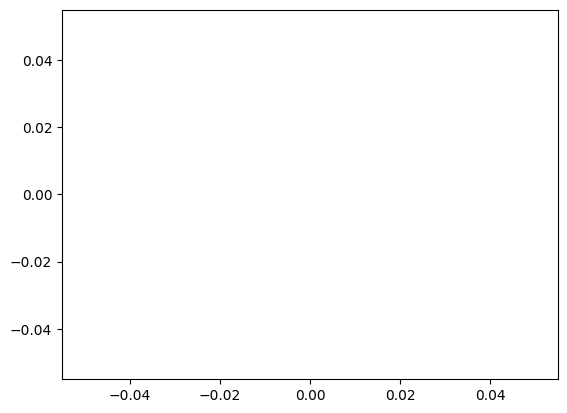

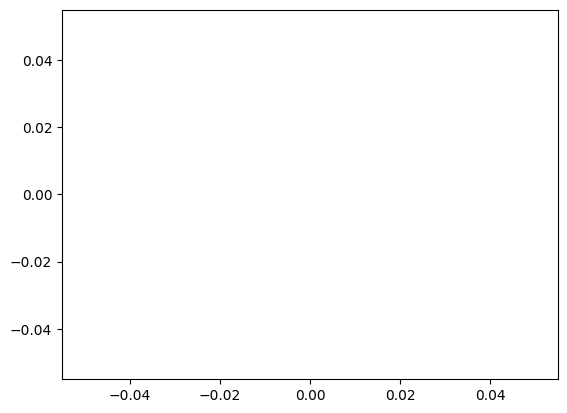

In [47]:
anm = CurveAnimation()

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_iter = dataset
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        # print(src.shape, tgt.shape)
        src = src.T.to(DEVICE)
        tgt = tgt.T.to(DEVICE)

        # tgt_input = tgt[:, :-1]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_one_out_mask(src, tgt)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt)
        # logits = model(src, tgt[:, :])
        tokens = generate_tokens(logits)

        optimizer.zero_grad()

        # tgt_out = tgt[:, 1:]
        tgt_out = tgt[:, :]
        # print(decode_tokens(tgt_out))
        # print(decode_tokens(tokens))

        hit_rate = ((tgt_out == tokens).sum() / count_words(tgt_out)).cpu().numpy()[()]
        # print()
        anm.add_data(hit_rate)
        
        loss = loss_fn(logits.transpose(-1, -2), tgt_out)
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    # return losses / len(list(train_dataloader))
    return anm.curve_ma[-1]


In [48]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [49]:
# model = Transformer(embed_dim=128, src_vocab_size=src_vocab_size,
#                     target_vocab_size=target_vocab_size, seq_length=30,
#                     num_layers=16, expansion_factor=4, n_heads=16,
#                     target_mask_fn=target_one_out_mask)

# transformer = model
# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

# transformer = transformer.to(DEVICE)


## Model

In [50]:
continue_previous = True
pickle_file = f'{states_dir}/prot_seq_transformer.pickle'
# continue_previous = False

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

if continue_previous and os.path.exists(pickle_file):
    transformer = pickle.load(open(pickle_file, 'rb'))
else:
    model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=30,
                    num_layers=3, expansion_factor=4, n_heads=16,
                    target_mask_fn=target_one_out_mask)


    transformer = model
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    
    transformer = transformer.to(DEVICE)

In [51]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-9)

## Training

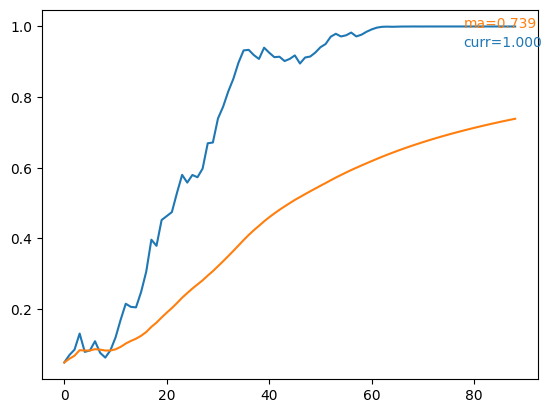

KeyboardInterrupt: 

In [52]:
NUM_EPOCHS = 20

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    # if epoch % 10 == 0:

print(( f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
pickle.dump(transformer, open(pickle_file, 'wb'))

In [ ]:
plt.plot(anm.curve_y)

In [53]:
pickle.dump(transformer, open(pickle_file, 'wb'))